In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

### Ratings

In [2]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], unit='s')

In [3]:
n_ratings = ratings.shape[0]
n_users = ratings.userId.nunique()
n_items = ratings.movieId.nunique()

print('Number of ratings:', n_ratings)
print('Number of users:', n_users)
print('Number of items:', n_items)
print('Average number of ratings per user:', round(n_ratings/n_users, 2))
print('Average number of ratings per item:', round(n_ratings/n_items, 2))

Number of ratings: 100836
Number of users: 610
Number of items: 9724
Average number of ratings per user: 165.3
Average number of ratings per item: 10.37


In [4]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.rename(columns={'movieId': 'n_ratings'}, inplace=True)
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


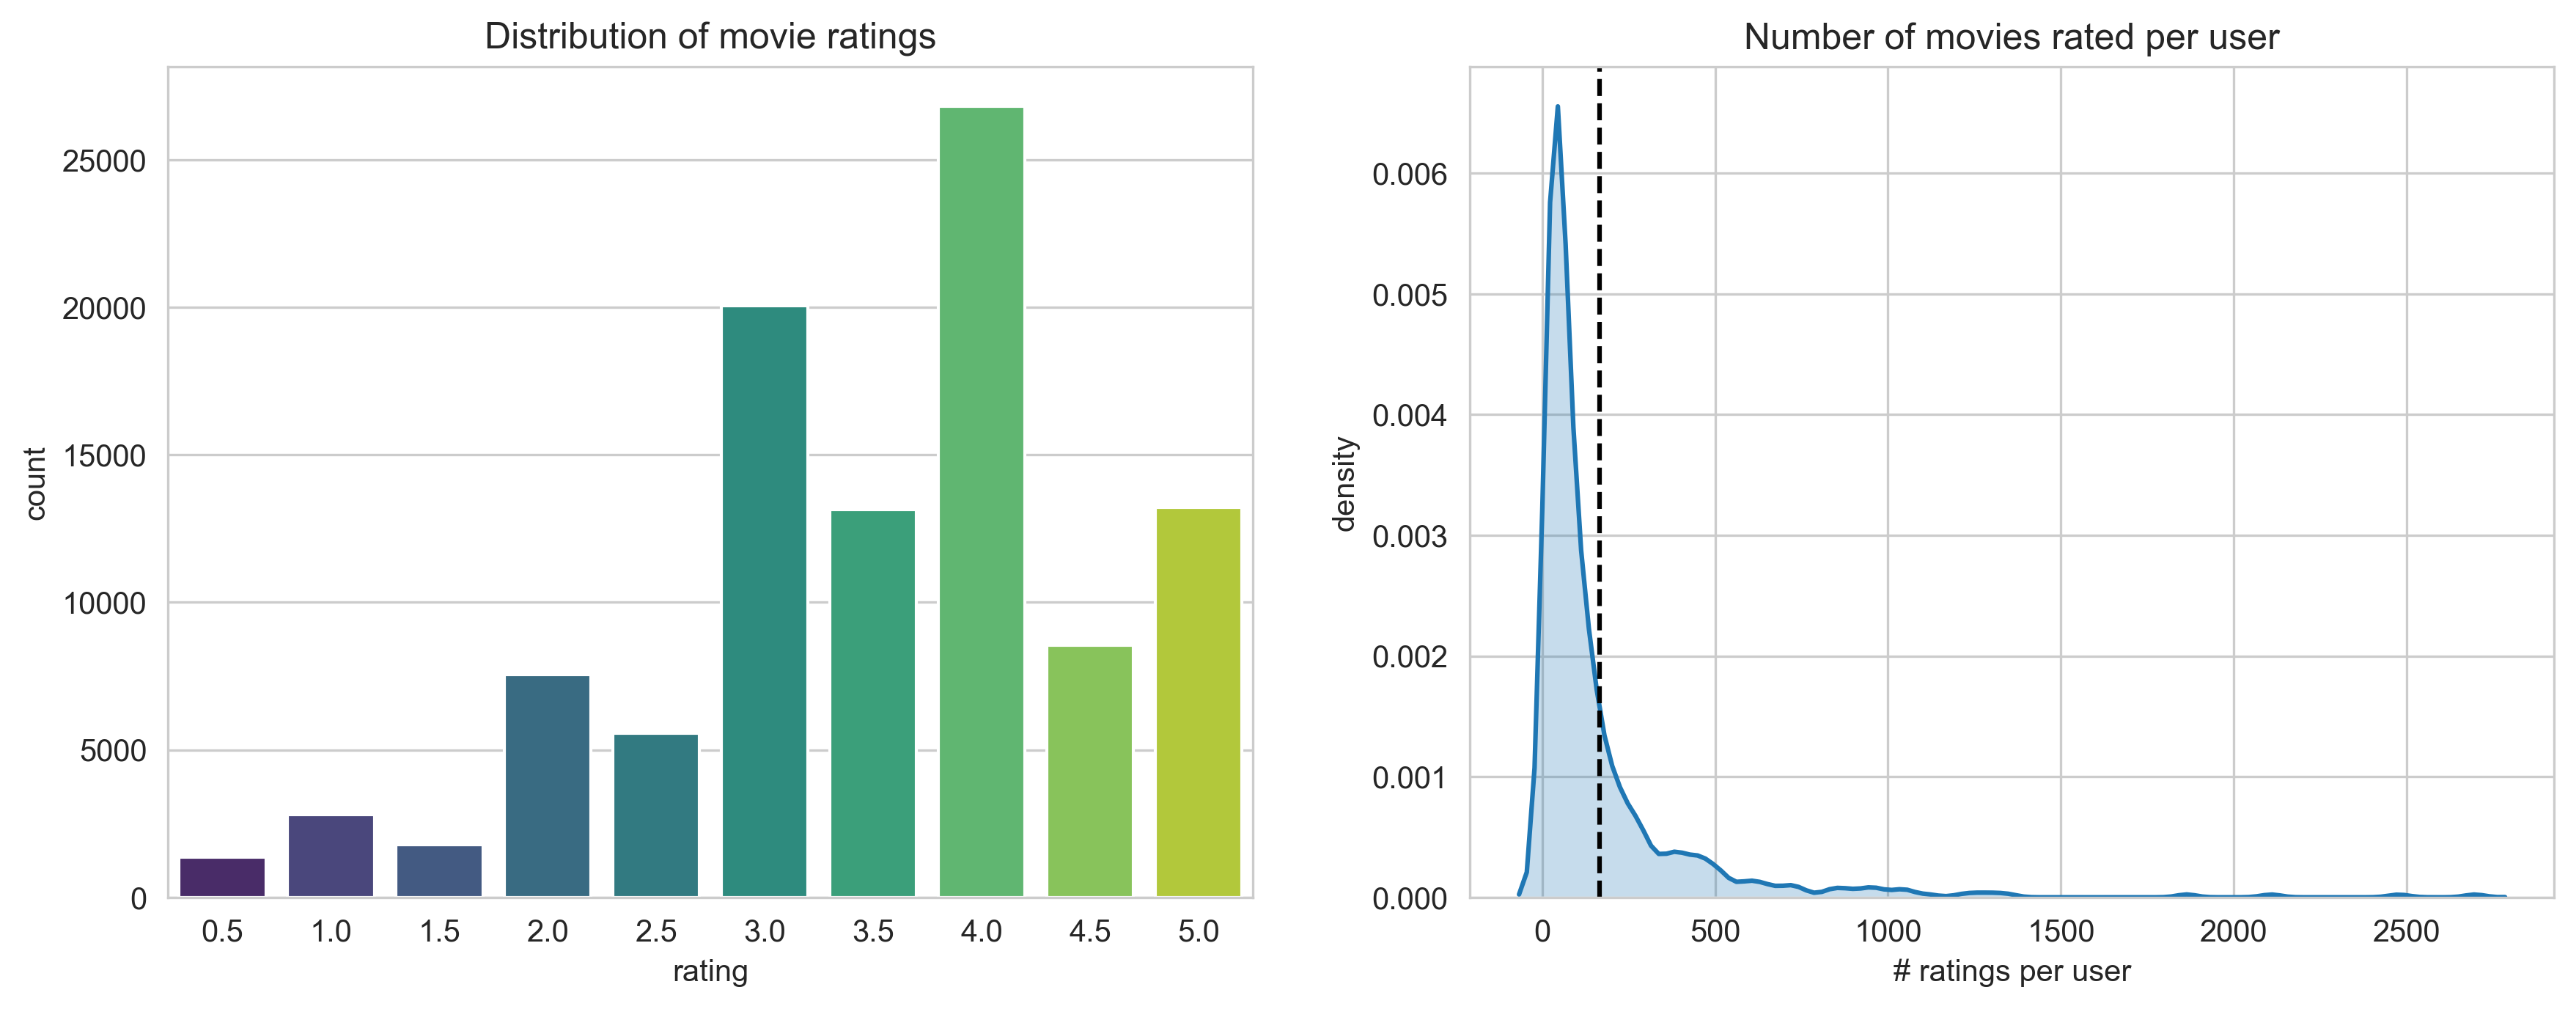

In [5]:
sns.set_style('whitegrid')
plt.figure(figsize=(14,5), dpi=300)

plt.subplot(1, 2, 1)
ax = sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of movie ratings')

plt.subplot(1, 2, 2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel('# ratings per user')
plt.ylabel('density')
plt.title('Number of movies rated per user')

plt.show()

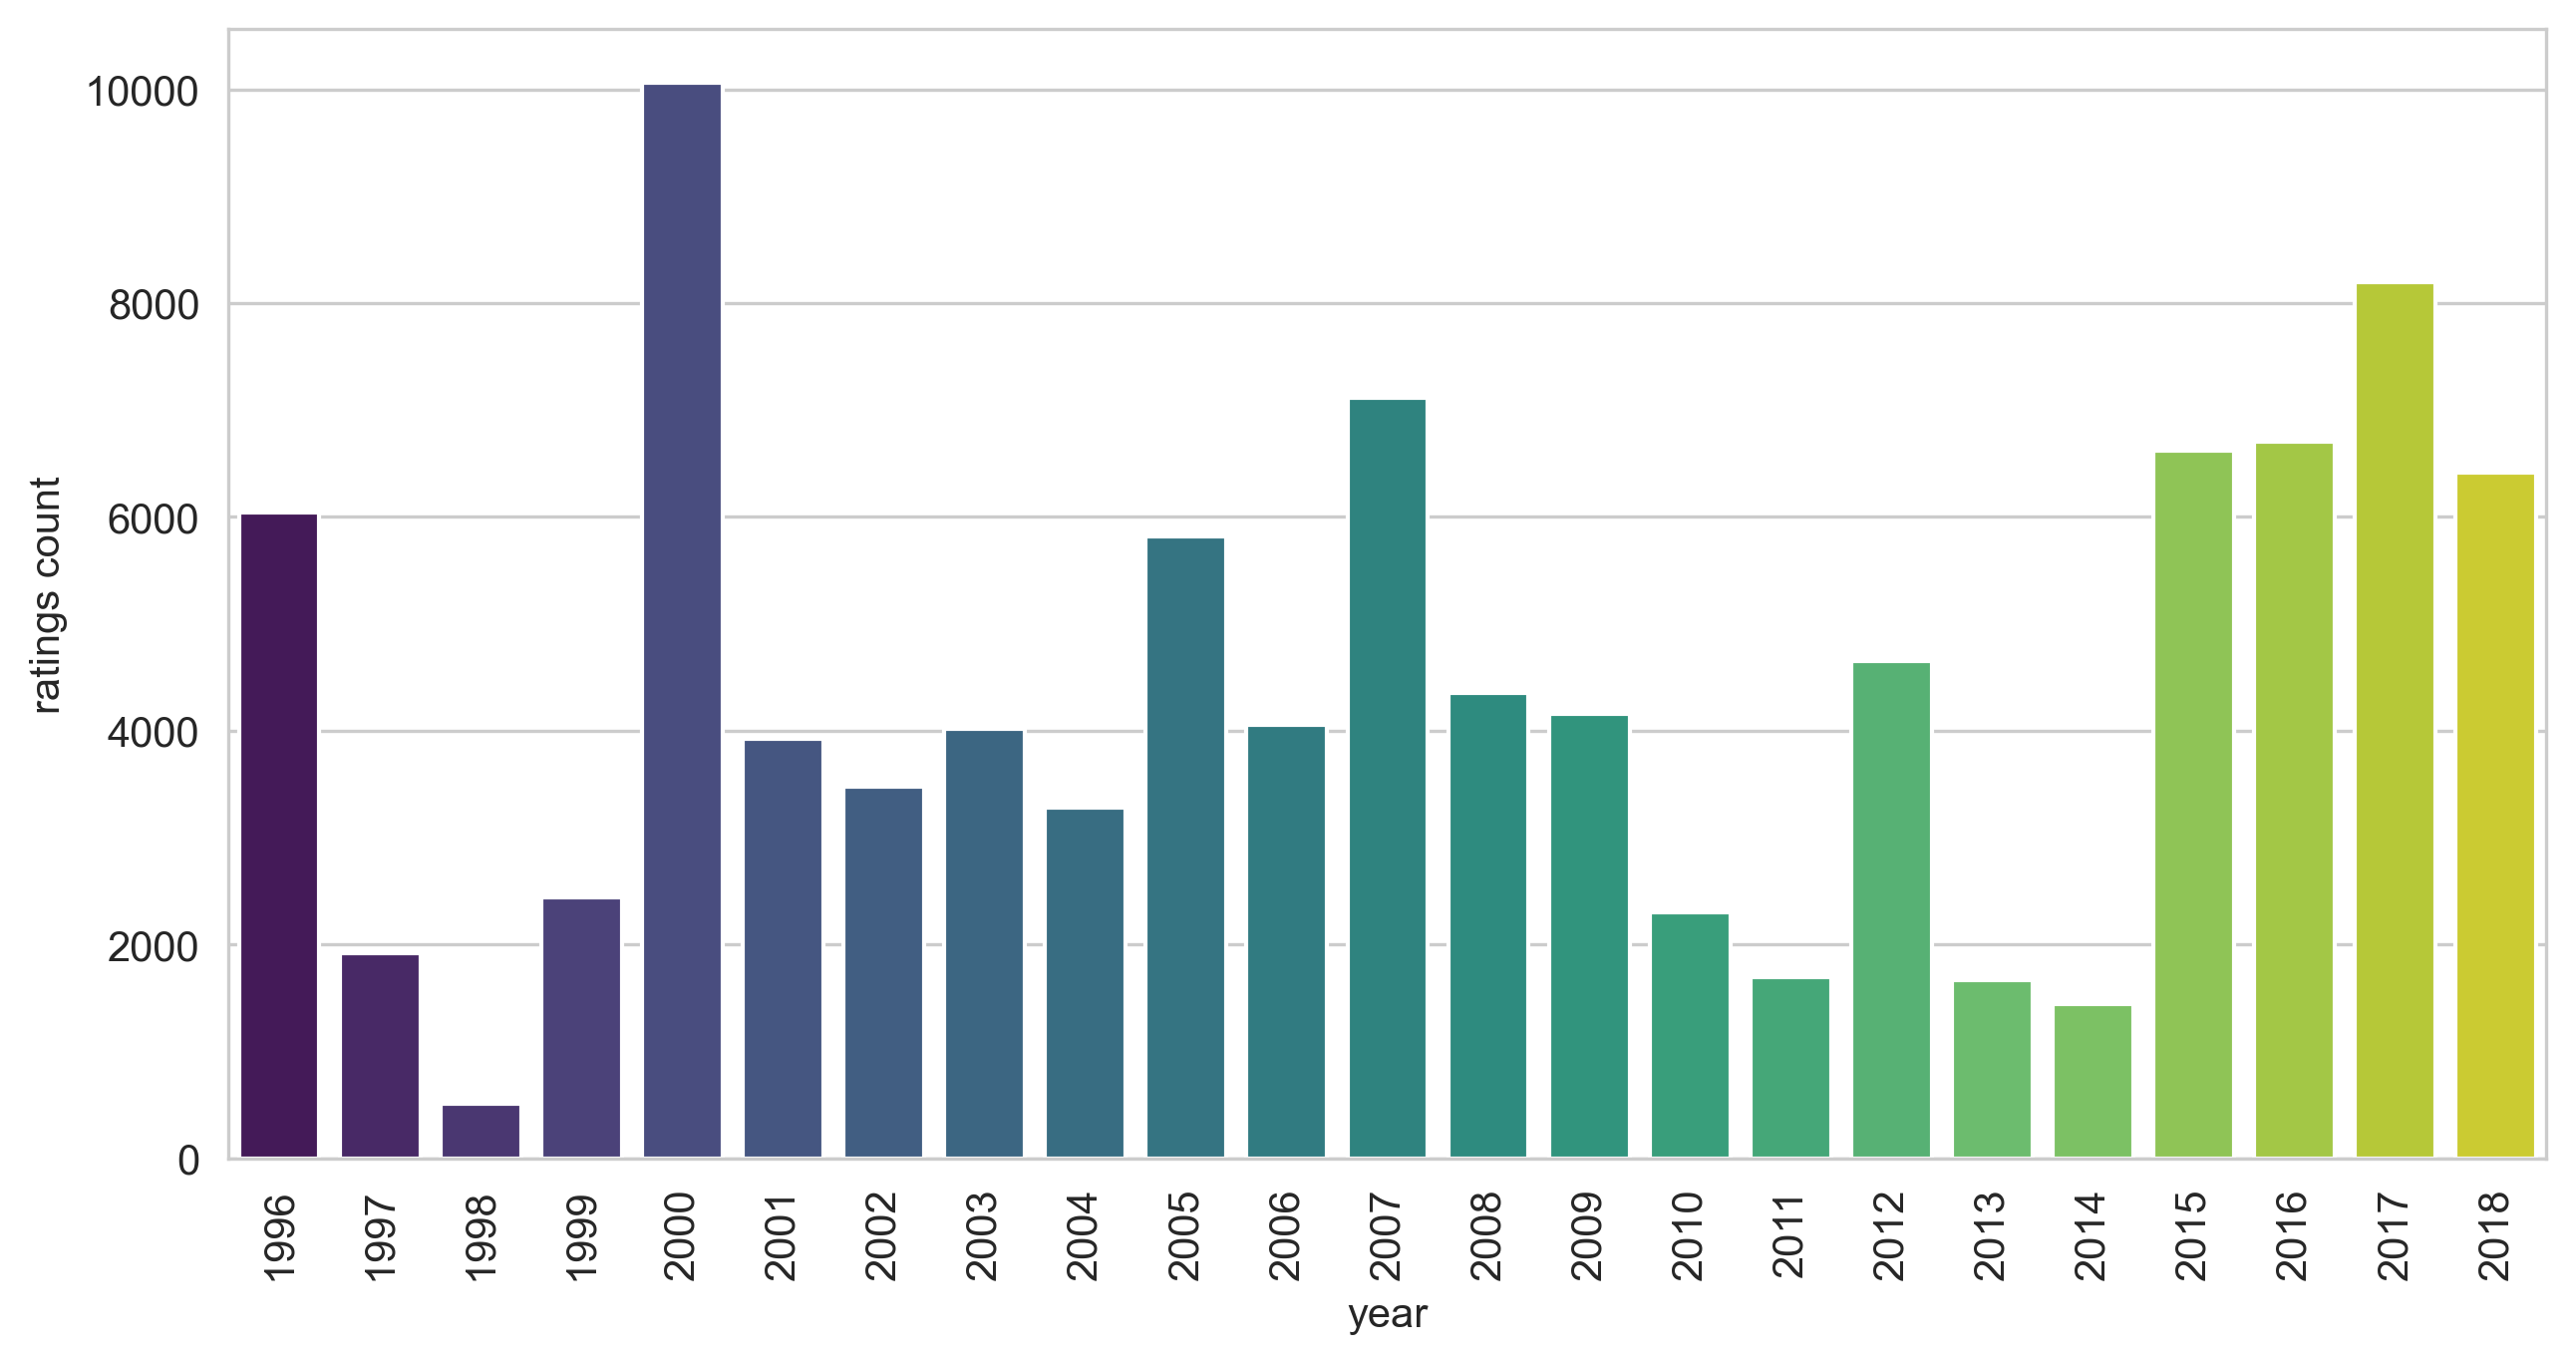

In [6]:
year_count = Counter(str(timestamp).split('-')[0] for timestamp in ratings['timestamp'])
year_count_df = (
    pd.DataFrame([year_count]).T
    .reset_index()
    .rename(columns={'index':'year', 0:'ratings count'})
    .sort_values('year')
)

plt.figure(figsize=(10,5), dpi=300)
sns.barplot(x='year', y='ratings count', data=year_count_df, palette='viridis')
plt.xticks(rotation=90)
plt.show()

### Movies

In [7]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

In [8]:
genre_count = Counter(g for genres in movies['genres'] for g in genres)
movies = movies[movies['genres']!='(no genres listed)']
del genre_count['(no genres listed)']

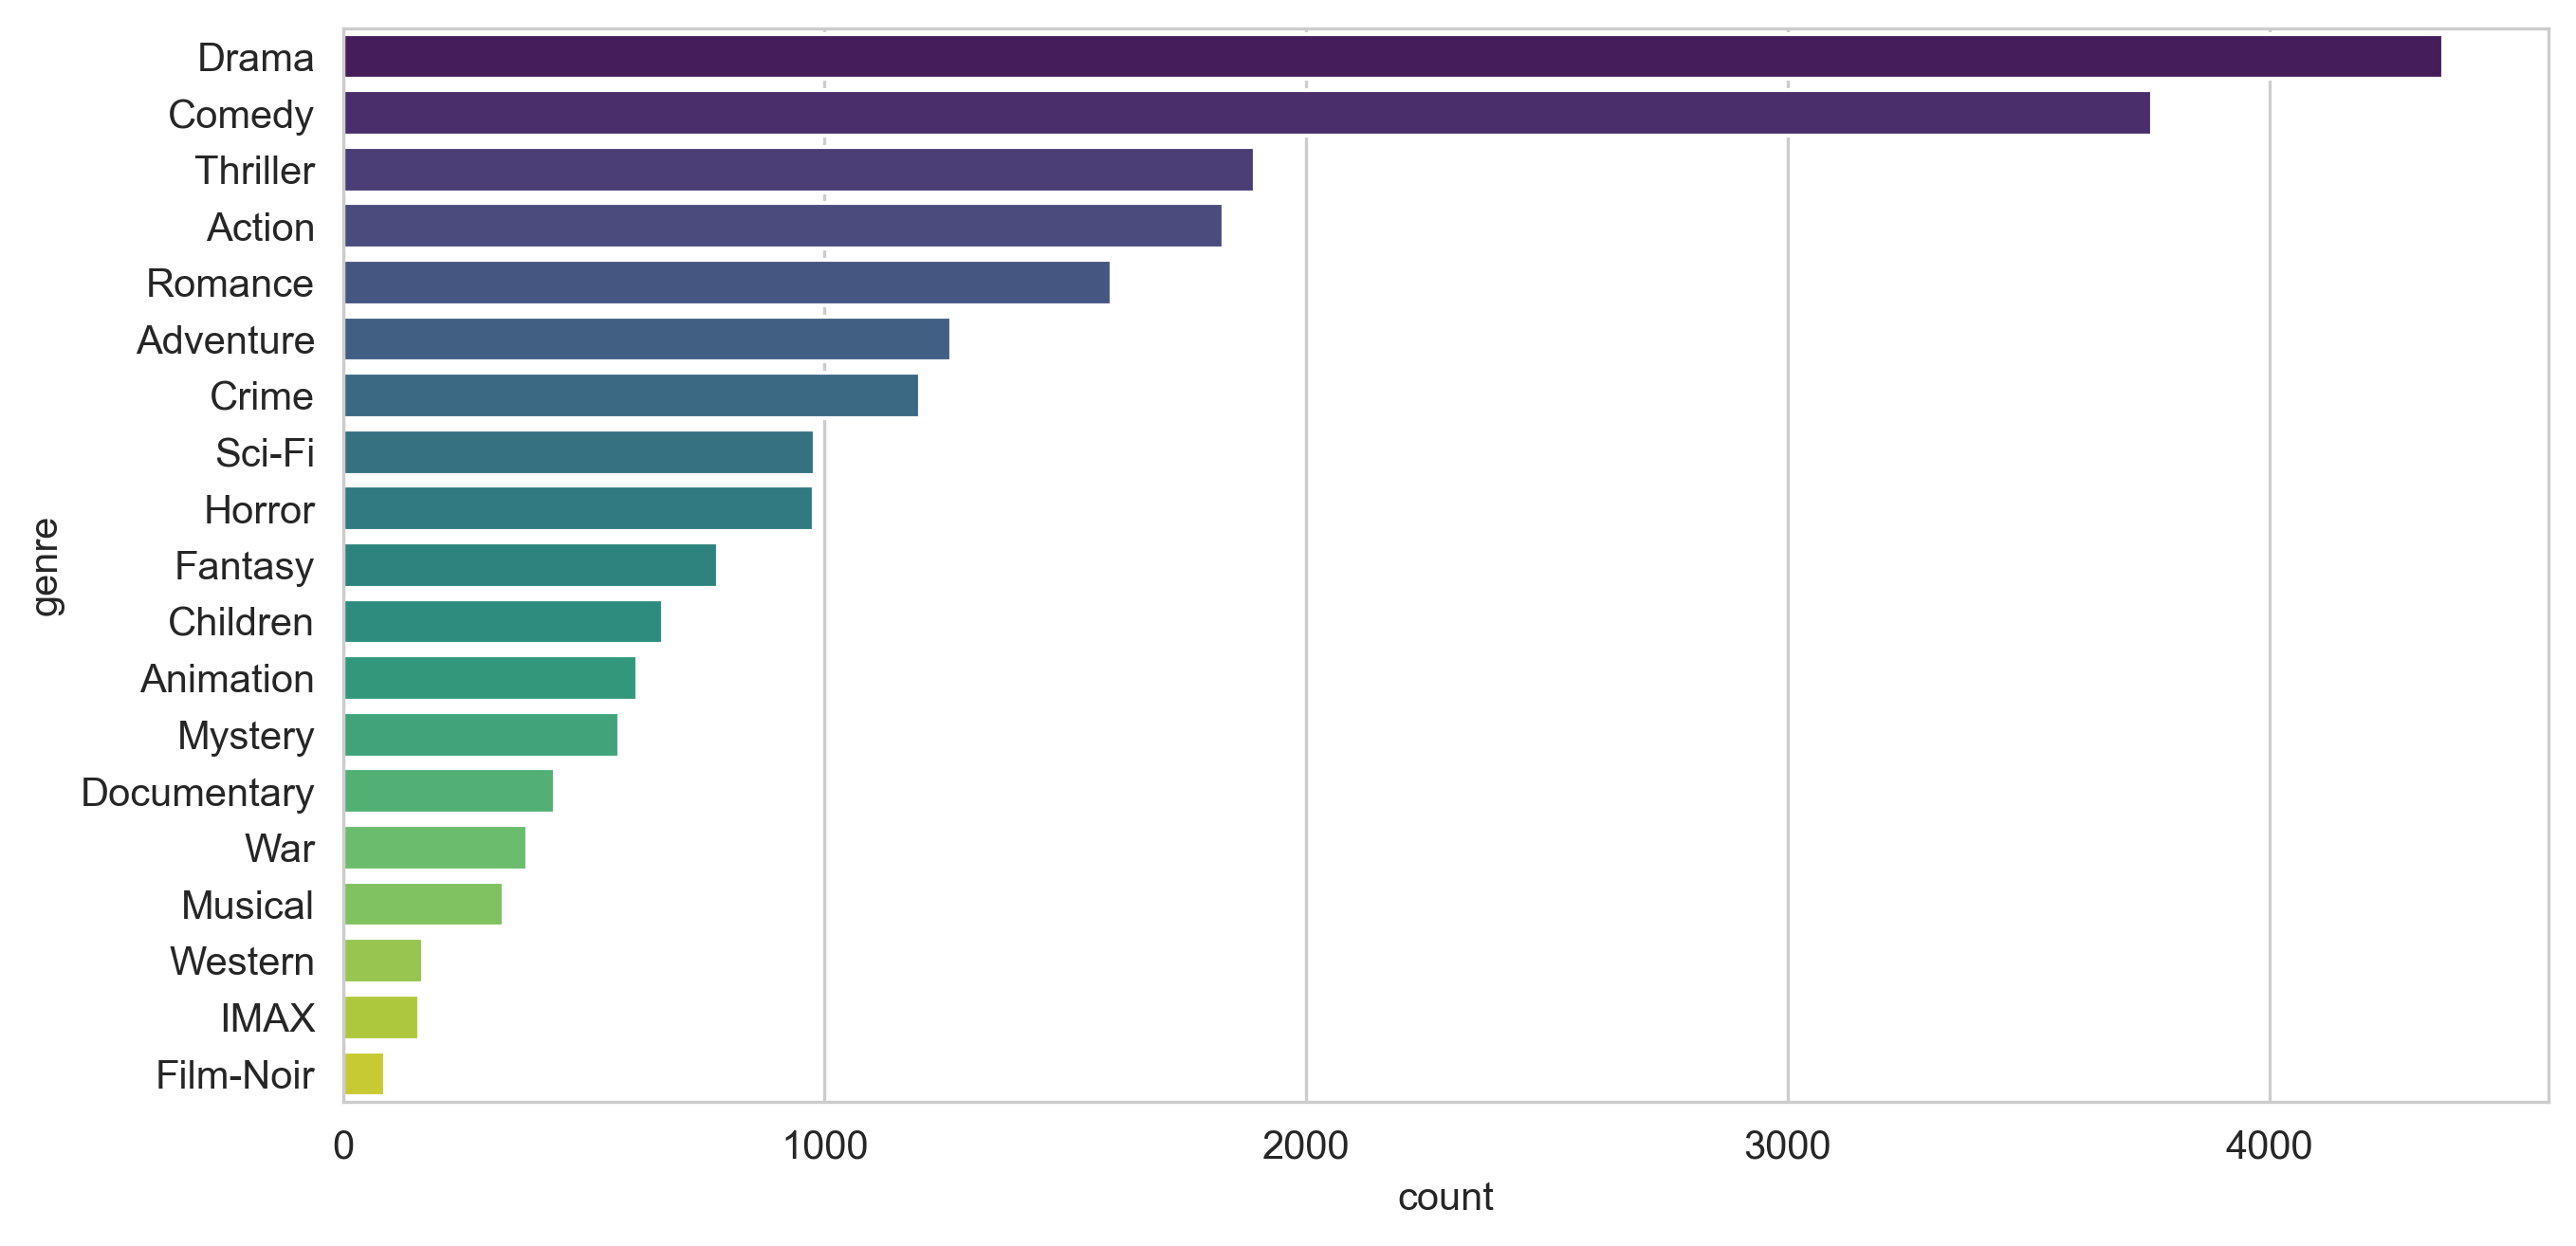

In [9]:
genre_count_df = (
    pd.DataFrame([genre_count]).T
    .reset_index()
    .rename(columns={'index':'genre', 0:'count'})
    .sort_values('count', ascending=False)
)
plt.figure(figsize=(10,5), dpi=300)
sns.barplot(x='count', y='genre', data=genre_count_df, palette='viridis')
plt.show()

### Tags

In [10]:
tags = pd.read_csv('ml-latest-small/tags.csv')

Tags word cloud: 


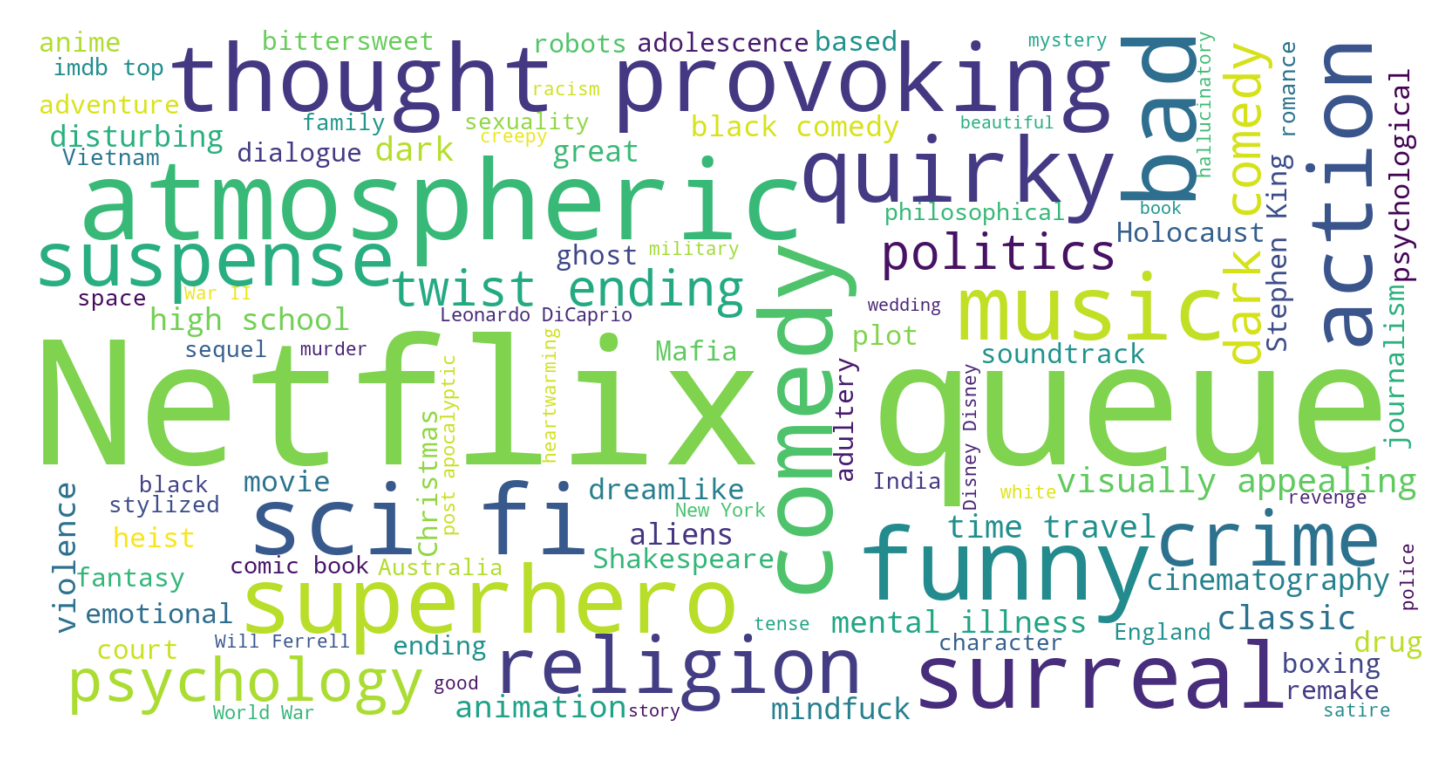

In [11]:
from PIL import Image
from wordcloud import WordCloud

# Concatenate tags
text = " ".join(tag for tag in tags['tag'])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=200, max_words=100, width=1600, height=800, background_color="white").generate(text)

print('Tags word cloud: ')

# Display the generated image:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Non-Personalized Recommender

In [12]:
utility_matrix = ratings.pivot_table(values='rating', index='userId', columns='movieId')

**Mean rating**

In [13]:
top_mean = pd.concat([utility_matrix.mean()[utility_matrix.count() >= 20], utility_matrix.count()[utility_matrix.count() >= 20]], axis=1)
top_mean.rename(columns={0:'mean rating', 1: '# of ratings'}, inplace= True)
top_mean.sort_values(by=['mean rating'], ascending=False, inplace=True)
top_mean = pd.merge(top_mean, movies[['movieId', 'title']], on='movieId')
top_mean = top_mean[['movieId', 'title', '# of ratings', 'mean rating']]

In [14]:
print('Top 10 movies with the highest mean rating (number of ratings > 20): ')
top_mean.head(10)

Top 10 movies with the highest mean rating (number of ratings > 20): 


,movieId,title,# of ratings,mean rating
0,1104,"Streetcar Named Desire, A (1951)",20,4.475000
1,318,"Shawshank Redemption, The (1994)",317,4.429022
2,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),27,4.333333
3,898,"Philadelphia Story, The (1940)",29,4.310345
4,475,In the Name of the Father (1993),25,4.300000
5,1204,Lawrence of Arabia (1962),45,4.300000
6,246,Hoop Dreams (1994),29,4.293103
7,858,"Godfather, The (1972)",192,4.289062
8,1235,Harold and Maude (1971),26,4.288462
9,168252,Logan (2017),25,4.280000


**% ratings 4+**

In [15]:
top_4p = pd.concat([(utility_matrix[utility_matrix >= 4].count()/utility_matrix.count())[utility_matrix.count() >= 20], 
           utility_matrix[utility_matrix >= 4].count()[utility_matrix.count() >= 20],
          utility_matrix.count()[utility_matrix.count() >= 20]], axis=1)
top_4p.rename(columns={0:'% of ratings 4+', 1: '# of ratings 4+', 2: '# of ratings'}, inplace= True)
top_4p.sort_values(by=['% of ratings 4+'], ascending=False, inplace=True)
top_4p = pd.merge(top_4p, movies[['movieId', 'title']], on='movieId')
top_4p = top_4p[['movieId', 'title', '# of ratings 4+', '# of ratings', '% of ratings 4+']]

In [16]:
print('Top 10 movies with the highest % of ratings 4+ (number of ratings > 20): ')
top_4p.head(10)

Top 10 movies with the highest % of ratings 4+ (number of ratings > 20): 


,movieId,title,# of ratings 4+,# of ratings,% of ratings 4+
0,930,Notorious (1946),19,20,0.950000
1,1104,"Streetcar Named Desire, A (1951)",18,20,0.900000
2,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),24,27,0.888889
3,475,In the Name of the Father (1993),22,25,0.880000
4,926,All About Eve (1950),21,24,0.875000
5,933,To Catch a Thief (1955),20,23,0.869565
6,318,"Shawshank Redemption, The (1994)",274,317,0.864353
7,3504,Network (1976),19,22,0.863636
8,1203,12 Angry Men (1957),49,57,0.859649
9,1276,Cool Hand Luke (1967),48,57,0.842105


**Bayesian Average**

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

In [17]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats = movie_stats[['movieId', 'title', 'count', 'mean', 'bayesian_avg']]

print('Top 10 movies with the highest Bayesian Average: ')
movie_stats.sort_values('bayesian_avg', ascending=False).head(10)

Top 10 movies with the highest Bayesian Average: 


,movieId,title,count,mean,bayesian_avg
277,318,"Shawshank Redemption, The (1994)",317,4.429022,4.392070
659,858,"Godfather, The (1972)",192,4.289062,4.236457
2224,2959,Fight Club (1999),218,4.272936,4.227052
224,260,Star Wars: Episode IV - A New Hope (1977),251,4.231076,4.192646
46,50,"Usual Suspects, The (1995)",204,4.237745,4.190567
921,1221,"Godfather: Part II, The (1974)",129,4.259690,4.185490
461,527,Schindler's List (1993),220,4.225000,4.181672
913,1213,Goodfellas (1990),126,4.250000,4.174905
6693,58559,"Dark Knight, The (2008)",149,4.238255,4.174762
897,1196,Star Wars: Episode V - The Empire Strikes Back...,211,4.215640,4.170989
